In [28]:
%matplotlib inline

import pysam
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib
import sys
import os
#matplotlib.use('Agg')
import seaborn as sns
import matplotlib.pyplot as plt
import ast
matplotlib.rcParams['figure.figsize'] = [16, 9]
sns.set_context("poster")

TBL="../methyl_calls_CD4_stim_DS76351/temp/mods/000758.pkl"
TBL="../methyl_calls_CD4_stim_DS76351/results/calls.pkl"
print(pd.__version__)
print(pd.__path__)

0.24.2
['/net/eichler/vol26/7200/software/modules-sw/miniconda/4.5.12/Linux/RHEL6/x86_64/envs/python3/lib/python3.6/site-packages/pandas']


In [44]:
# read in the data 
"""
tbl_d = {"name":[], "np":[], "position":[], "qual":[]}
for idx, line in enumerate(open(TBL)):
    name, NP, positions, qualities = line.split("\t")
    positions = ast.literal_eval(positions)
    qualities = ast.literal_eval(qualities)
    for p, q in zip(positions, qualities):
        tbl_d["name"].append(name)
        tbl_d["np"].append(int(NP))
        tbl_d["position"].append(p)
        tbl_d["qual"].append(q)
        
    if(idx == 100000): break

df = pd.DataFrame(tbl_d)
df["dist"] = df.position.diff(); 
mask = df.name != df.name.shift(1)
df.loc[mask,"dist"] = np.nan
"""

df = pd.read_pickle(TBL)

# get space between mods 
dists = []
for x in df.positions: dists.append( np.diff(x) )
dists = np.concatenate(dists, axis = None)

plot_dists = dists[ dists < np.quantile(dists, .99999)  ]


# get qualities by number of passes 
qual_df = pd.DataFrame({
    "np": np.repeat( df.np, df.qualities.apply(len) ),
    "QV": np.concatenate(df.qualities) 
})


Text(0.5, 0, 'Distance between m6A (accessible) sites')

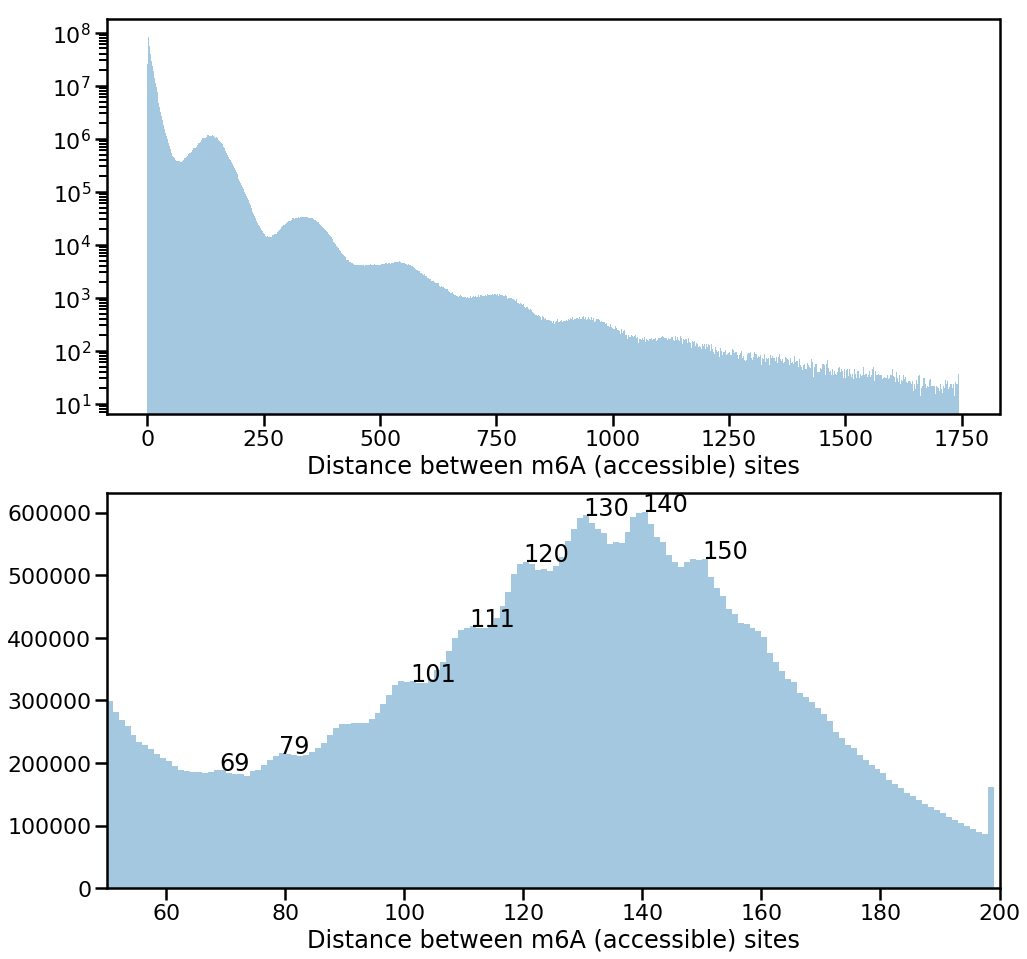

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,16))

sns.distplot( plot_dists, kde=False, bins=range(0,int(max(plot_dists)) +1, 2), hist_kws={'log':True}, ax=ax1)
ax1.set_xlabel("Distance between m6A (accessible) sites")


BOT=50; TOP=200
sns.distplot( plot_dists, kde=False, bins=range(BOT,TOP), ax=ax2); ax2.set_xlim(BOT,TOP)
heights = np.array([h.get_height() for h in ax2.patches] )
peaks, _= find_peaks(heights, distance=5, width=1)
for peak in peaks:
    ax2.text(peak+BOT, heights[peak], peak+BOT)
    
ax2.set_xlabel("Distance between m6A (accessible) sites")


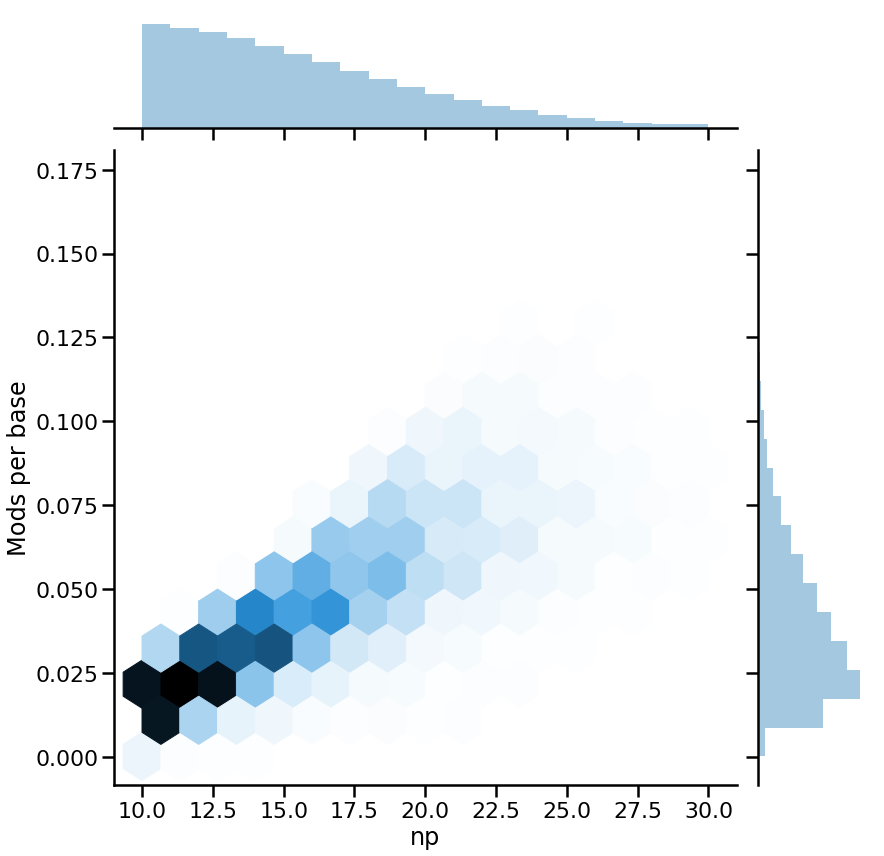

In [5]:
MAX=30
MIN=10
df["Mods per base"] =  df.positions.apply(len) / df.length
tmp = df[ (df.np >= MIN) & (df.np <= MAX) ]

joint_kws=dict(gridsize=15) 
fig = sns.jointplot(tmp.np, tmp["Mods per base"] , kind="hex", height=12,  
                    marginal_kws=dict(bins=MAX-MIN), joint_kws = joint_kws)

fitting
plotting


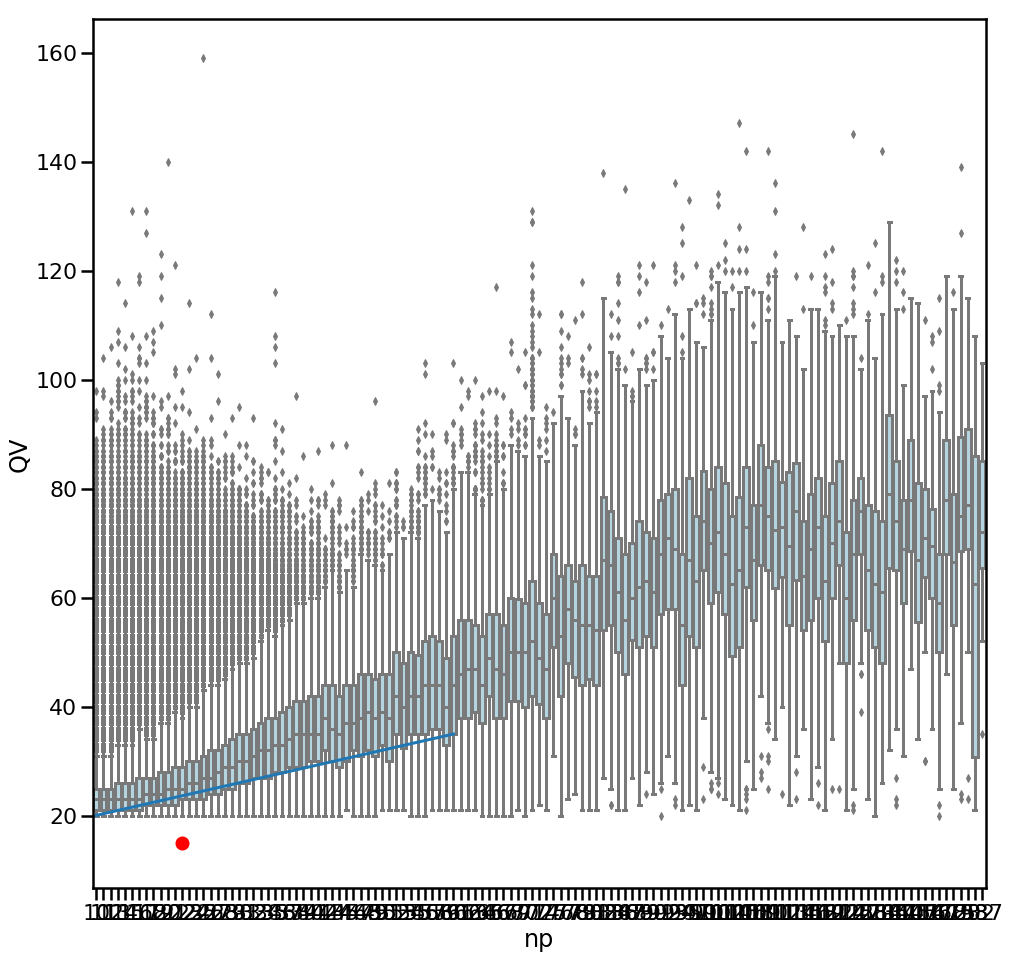

In [101]:
tmp = qual_df
#sns.lmplot(x="np", y="QV", data=tmp, x_estimator=np.mean)
#fig = sns.jointplot(tmp.np, tmp.QV , kind="hex", height=12, marginal_kws=dict(bins=MAX-MIN), joint_kws = joint_kws)
print("fitting")
#fig = sns.lmplot(x="np", y="QV", data=qual_df, x_estimator=np.median, height=12)
m,b = np.polyfit(tmp.np, tmp.QV, 1)
print("plotting")

fig, ax = plt.subplots(figsize=(16,16))
ax = sns.boxplot(x = "np", y = "QV", color="lightblue", data=tmp, ax=ax)
x = np.linspace(qual_df.np.min() , qual_df.np.quantile(0.9999), 1000) - qual_df.np.min()
ax.plot(x, m*x +b )
ax.scatter([22 - qual_df.np.min()],[15] , color="red")

In [130]:
possible_np = np.arange(qual_df.np.min(), qual_df.np.quantile(0.9999) + 1)
fit = np.round(m*possible_np + b)
rec_qv = fit - [min(fit) - 10]


min_qv = {x:y for x,y in zip(possible_np, rec_qv) }

In [ ]:

def reaches_qv(row):
    MIN = min(min_qv.keys()); MAX = max(min_qv.keys())
    if(row.np < MIN):
       return( row.QV >= min_qv[MIN] )
    if(row.np > MAX):
        return( row.QV >= min_qv[MAX])
    return(row.QV >= min_qv[row.np]) 


x = qual_df.apply(reaches_qv, axis=1)



In [ ]:
print(x.shape)
x.sum()

In [135]:

ccs = pysam.AlignmentFile(CCS, check_sq=False)
nps, lengths = list(zip(*[ (rec.get_tag("np"), rec.query_length)  for rec in ccs.fetch(until_eof=True)]))
ccs_df = pd.DataFrame( {"np":nps, "length":lengths})


,np,QV
0,15,21
0,15,20
0,15,26
0,15,24
0,15,29


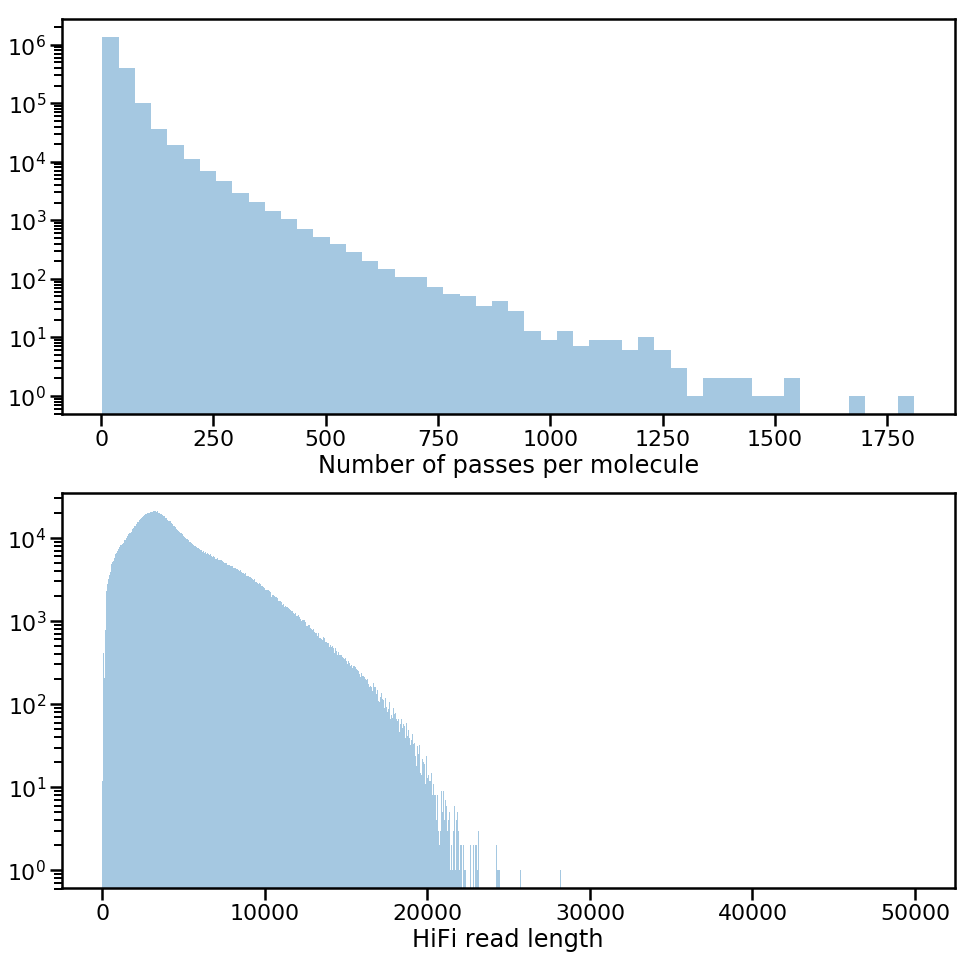

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,16))

sns.distplot( ccs_df.np, kde=False, ax=ax1)
ax1.set_yscale('log')
ax1.set_xlabel("Number of passes per molecule")

sns.distplot( lengths, kde=False, bins=range(0,50000,50), ax=ax2); 
ax2.set_yscale('log')
ax2.set_xlabel("HiFi read length")


fig.savefig(O2)

In [127]:
#MM:Z:([ACGTUN][-+][a-z]+(,[0-9]+)*;)*

'''MP:Z:qualities
The optional MP tag lists the Phred qualities of each modification listed in the MM tag in the order they
occur. The qualities are encoded in the same manner as the primary QUAL field; one byte per quality
with ASCII value Phred score + 33. A space character (‘ ’) should be used as a separator between
concatenated quality strings when multiple modification lists are present in the MM tag. The length
should match the number of position deltas from MM plus 1 per space character required.
For example “MM:Z:C+m,5,12,3;C+h,57;” may have an associated quality tag of “MP:Z:5EB /”.
Where multiple modification types are listed together, such as in “MM:Z:C+mh,5,12,3;” the quality
values are interleaved in order (m at 6, h at 6, m at 19, h at 19 and so on), giving 6 quality values in
total for this example.
Quality values for ambiguity codes give the likelihood that the modification is one of the possible codes
compatible with that ambiguity code. For example MM:Z:C+C,10; MP:Z:+ indicates a C call with an
unspecified modification and the phred score of 10 (ASCII value +). This corresponds to a 90% chance
of the base being modified.
To represent several possible modifications at the same site the MP tag can be used to indicate the
probabilities of each possibility. The values used should be absolute probabilities, not relative between
the alternatives. For example, a C base that has 95% chance of being modified with 5mC being three
times more likely than 5hmC will encode 5mC with 67.5% probability (0.9 ∗ 0.75 giving phred score
5, ASCII value &)and 5hmC with 22.5% probability (0.9 ∗ 0.25 giving phred score 1, ASCII value ").
This could be represented with “MM:Z:C+m,10;C+h,10; MP:Z:" &”.'''

'''MM:Z:([ACGTUN][-+][a-z]+(,[0-9]+)*;)*
The first character is the unmodified “fundamental” base as reported by the sequencing instrument. It
must be one of A, C, G, T, U (if RNA) or N. Note N may be used to match any base rather than specifically
an N call by the sequencing instrument. This may be used in situations where the base modification is
not a derivation of a standard base type. This is followed by either plus or minus indicating the strand
the modification was observed on (relative to the original sequenced strand of SEQ with plus meaning
same orientation3
), and one or more base modification symbols. This is then followed by a comma
separated list of how many unmodified seq bases of the stated base type to skip, stored as a delta to
the last and starting with 0 as the first (or next) base, starting from the uncomplemented 5’ end of
the SEQ field. Hence this number series is comparable to the numbers in an MD tag, albeit potentially
reverse-complemented.
For example C+m,5,12,0; tells us there are three 5-Methylcytosine bases in the original orientation
SEQ. The first 5 C bases are unmodified and the 6th is modified, as are the 19th (with 12 between the
6th and 19th) and 20th. Similarly G-m,14; indicates the 15th G is a 5-Methylcytosine on the opposite
strand (still counting from the 5’ end).
This permits modifications to be listed on either strand with the rare potential for both strands to
have a modification at the same site.
Note it is permitted for the coordinate list to be empty (for example MM:Z:C+m;), which may be used
as an explicit indicator that this base modification is not present. It is not permitted for coordinates
to be beyond the length of the sequence.
When multiple modifications are listed, for example C+mh,5,12,0;, it indicates the modification may
be any of the stated bases. The associated confidence values in the MP tag may be used to determine
the relative likelihoods between the options. Except for the order in which the values are store in MP
the above example is equivalent to C+m,5,12,0;C+h,5,12,0;.'''


'''    +----------+----------+-------------------------------+
    |*Column*  |*Name*    |*Content*                      |
    +----------+----------+-------------------------------+
    |1         |contig    |the chromosome name            |
    +----------+----------+-------------------------------+
    |2         |feature   |The feature type               |
    +----------+----------+-------------------------------+
    |3         |source    |The feature source             |
    +----------+----------+-------------------------------+
    |4         |start     |genomic start coordinate       |
    |          |          |(0-based)                      |
    +----------+----------+-------------------------------+
    |5         |end       |genomic end coordinate         |
    |          |          |(0-based)                      |
    +----------+----------+-------------------------------+
    |6         |score     |feature score                  |
    +----------+----------+-------------------------------+
    |7         |strand    |strand                         |
    +----------+----------+-------------------------------+
    |8         |frame     |frame                          |
    +----------+----------+-------------------------------+
    |9         |attributes|the attribute field            |'''

chr(0+1254)
chr(126)

'~'

In [49]:
def qual_to_char(num):
    return( chr( min(int(num) + 33, 126)) )

def make_diff_str(l):
    pre = 0; rtn = ""
    total = 0
    for x in l:
        inc = x-pre
        rtn += ",{}".format(inc); pre = x+1
        total += inc+1
    assert total == l[-1] +1 
    return(rtn)

def get_mod_tags(gff, read_name, mod_types=["m6A"]):
    pat = re.compile("([^=;]+)=(\d+\.*\d*);*")    
    qualf = "" # phred values for forward strand modification calls
    qualr = "" # phred values for reverse strand modification calls
    posf = []
    posr = []
    for rec in gff.fetch(reference=read_name):
        if(rec.feature in mod_types):
            ms = re.findall(pat, rec.attributes); atts = { atr: float(val)  for atr, val in ms }
            if("identificationQv" in atts):
                qual_char = qual_to_char(atts["identificationQv"]) 
                start = rec.start
                strand = rec.strand
                if(strand == "+"): 
                    qualf += qual_char
                    posf.append(start)
                elif(strand == "-"):
                    qualr += qual_char
                    posr.append(start)
                else:
                    raise("The strand must be indicated.")
    MM = ""; MP = ""
    if(len(posf) > 0):
        MM += "A+a{};".format(make_diff_str(posf))
        MP += "{}".format(qualf)
    if(len(posr) > 0):
        MM += "T-a{};".format(make_diff_str(posr))
        MP += " {}".format(qualr)
    
    if(len(MM) == 0):
        return(None)
    else:
        return({"MM":MM, "MP":MP})

#pysam.tabix_iterator(f, pysam.asGTF)
#pysam.tabix_index(f, preset="gff")

gff =  pysam.TabixFile("../methyl_calls_CD4_stim_DS75687/results/gff/000000.gff.bgz", parser=pysam.asGFF3())
contigs = set(gff.contigs)
bam = pysam.AlignmentFile("../methyl_calls_CD4_stim_DS75687/temp/refs/000000.bam", check_sq=False)

for aln in bam.fetch(until_eof=True):
    # skip reads that had no modifications 
    if(aln.query_name not in contigs):
        continue 
    
    new_tags = get_mod_tags(gff, read_name=aln.query_name)
    if(new_tags is not None):
        for tag in new_tags: aln.set_tag(tag, new_tags[tag])
    print(aln.tags)
    


[('RG', 'ad0bd482'), ('np', 88), ('rq', 1.0), ('sn', array('f', [9.751883506774902, 16.067602157592773, 3.650768518447876, 6.262381076812744])), ('zm', 3), ('MM', 'A+a,192,135,3,19,20,19,116,1,5,3,10,9,38,13,137,2,13,170,8,1,11,13,8,2,19,132,173,37,152,24,20,13,168,144,4,12,4,2,17,4,9,9,4,3;T-a,334,1706,4,8,13;'), ('MP', 'L{hOQXlC>OaOTSFHZagMG[dOQXFeY>HZBMWPRLVI<\\II &C*SC')]
[('RG', 'ad0bd482'), ('np', 27), ('rq', 0.9999749064445496), ('sn', array('f', [14.414607048034668, 21.139759063720703, 4.94558048248291, 8.927878379821777])), ('zm', 12), ('MM', 'A+a,31,9,1,9,5,26,3,3,3,11,14,5,6,98,9,3,6,4,6,6,7,9,10,1,8,3,1,7,12,145,1,8,3,7,6,14,1,38,126,21,3,5,7,4,17,152,5,5,4,2,8,1,3,15,2,11,8,1,113,12,3,6,1,15,2,5,4,11,4,114,2,14,1,11,14,2,11,17,163,7,0,15,9,4,4,2,17,110,23,4,9,13;T-a,2049;'), ('MP', "11)3+*(15.(6(6(,/%,/(;$642%'@75.,3$1+<(%6%,%---))-(H'A,2&.373;+8'1**)445(*),73+,&$?%'(68.3)8 0")]
[('RG', 'ad0bd482'), ('np', 6), ('rq', 0.9917404651641846), ('sn', array('f', [13.8510751724243

In [54]:
#
# mods per base 
#


ccs = pysam.AlignmentFile("../methyl_calls_CD4_stim_DS75687/results/ccs_with_mods.bam", check_sq=False)
nps = []; lengths =[]; nmods =[]; 
for rec in ccs.fetch(until_eof=True):
    if(rec.has_tag("MP")):
        nps.append(rec.get_tag("np")); 
        lengths.append(rec.query_length)
        nmods.append( len(rec.get_tag("MP")) -1)
        
ccs_df = pd.DataFrame( {"np":nps, "length":lengths, "nmods": nmods})



/net/eichler/vol26/7200/software/modules-sw/miniconda/4.5.12/Linux/RHEL6/x86_64/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


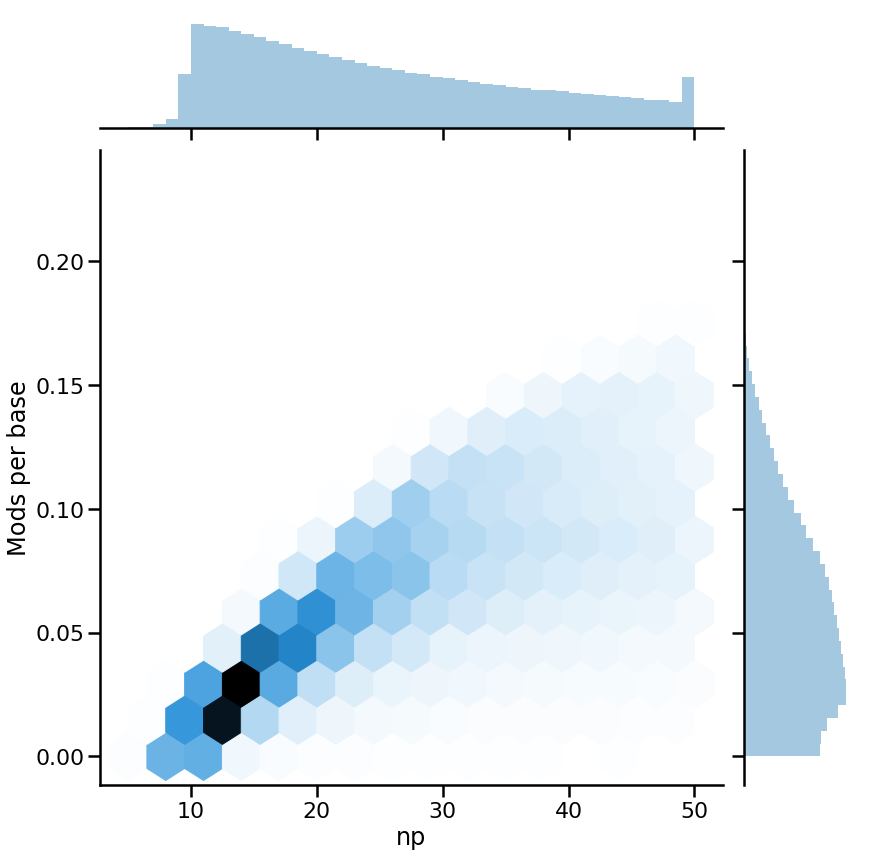

In [102]:
MAX=50;MIN=5
df = ccs_df[ (ccs_df.np <= MAX) & (ccs_df.np >= MIN)]
df["Mods per base"] =df.nmods/df.length
joint_kws=dict(gridsize=15)
fig = sns.jointplot( df.np, df["Mods per base"] , kind="hex", height=12,  
                    marginal_kws=dict(bins=(MAX-MIN)), joint_kws = joint_kws)

fig.savefig("../methyl_calls_CD4_stim_DS75687/results/np_vs_nmods.pdf")
